# Imports and dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

layerArray = [2, 4, 8, 16, 32]
gainArray  = []
lossArray  = []
trainError = []

#originalDataSet = pd.read_csv('dataset', sep=',',header = None)
originalDataSet = pd.read_csv('reduced_dataset', sep=',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    global trainError
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)         
        
        trainError.append(regressor.loss_curve_) #mlp
        
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):    
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    print()
    
    gainArray.append(np.mean(gainErrors))
    lossArray.append(np.mean(lossErrors))

def setMLP(layers):
    if layers == 2:
        return MLPRegressor(hidden_layer_sizes = (8, 8), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 4:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 8:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 32, 64, 32, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 16:
        return MLPRegressor(hidden_layer_sizes = (8, 16, 16, 32, 32, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)
    
    if layers == 32:
        return MLPRegressor(hidden_layer_sizes = (8, 8, 16, 16, 16, 16, 32, 32, 32, 32, 64, 64, 64, 64, 128, 128, 128, 128, 64, 64, 64, 64, 32, 32, 32, 32, 16, 16, 16, 16, 8, 4), activation = 'identity', learning_rate = 'constant', alpha = 0.001, random_state = 0)


# Plotting functions

In [4]:
def plotGainError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(layerArray, gainArray, 'sb-')
    axis.set_title("Gain error")
    axis.set_ylabel("Absolute error")
    axis.set_xlabel("Number of layers")
    #axis.legend(strategyArray)

    plt.show()

In [5]:
def plotLossError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(layerArray, lossArray, 'or--')
    axis.set_title("Loss error")
    axis.set_ylabel("Absolute error")
    axis.set_xlabel("Number of layers")
    #axis.legend(strategyArray)

    plt.show()

In [6]:
def plotDistribution(regressor, layers):
    features, result = loadDataset()

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    
    vfunc = np.vectorize(invertNorm)

    axis.scatter(vfunc(result[:, 0]), vfunc(result[:, 1]))
    axis.scatter(vfunc(predicted[:, 0]), vfunc(predicted[:, 1]), c = "m")
    
    axis.set_title("{} layers".format(layers))
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [7]:
def plotTrainError(regressor):
    ### Preparing data ###
    global trainError

    aux       = trainError[0]
    maxLength = len(trainError[0])
    
    for array in trainError:
        if len(array) < maxLength:
            maxLength = len(array)
        
    for i in range(1, len(trainError)):
        aux = np.add(aux[0: maxLength], trainError[i][0: maxLength])
    
    aux = np.divide(aux, 5)
    
    ### Plotting ###
    fig, axis = plt.subplots(figsize = (10, 5))
    axis.plot(aux)
    
    axis.set_title("MLP Training Error", fontsize = 16)
    axis.set_xlabel("Epoch", fontsize = 14)
    axis.set_ylabel("MSE", fontsize = 14)

    plt.show()

In [8]:
from sklearn.model_selection import learning_curve

def plotKNNTrainError(regressor):
    X, y = loadDataset()
    train_sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))  
    
    print(train_scores)
    '''
    axis.plot(aux)
    
    axis.set_title("MLP Training Error", fontsize = 16)
    axis.set_xlabel("Epoch", fontsize = 14)
    axis.set_ylabel("MSE", fontsize = 14)

    plt.show()
    '''

# Putting all together

[3.32093636 2.96202861 2.99953317 3.1383098  4.39777933] => 3.36 (+/- 1.06)
[2.08830158 2.29273619 1.61142771 1.81228388 3.67245398] => 2.30 (+/- 1.45)



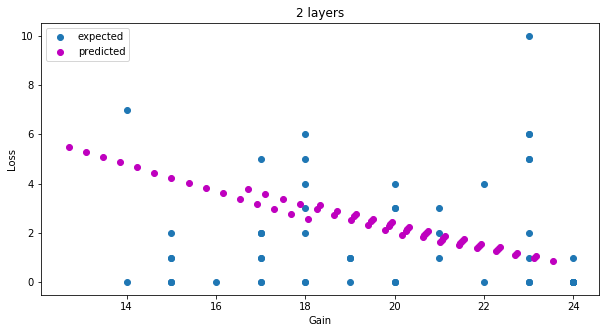

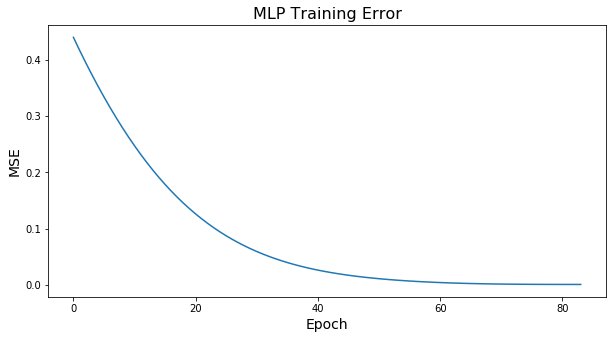

[5.34749186 5.93562523 5.1233934  6.66192132 6.3662423 ] => 5.89 (+/- 1.17)
[21.47042403 21.47866296 24.90220325 25.08294835 34.14641771] => 25.42 (+/- 9.28)



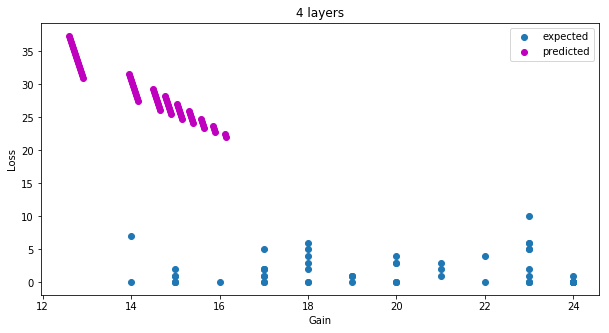

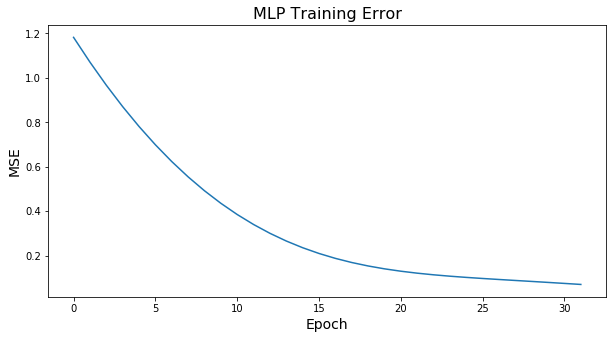

[16.26276252 15.27759515 16.23686243 14.52661498 12.66417467] => 14.99 (+/- 2.67)
[28.74825497 28.56001571 26.30234859 26.21778302 17.09321037] => 25.38 (+/- 8.56)



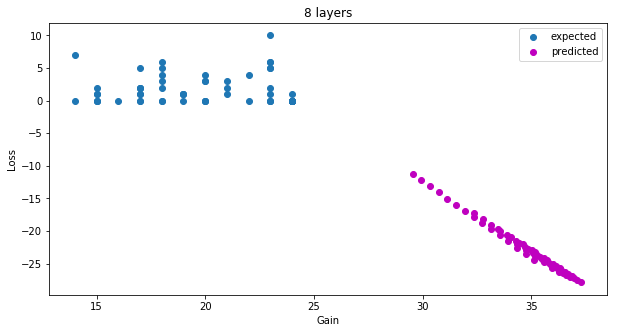

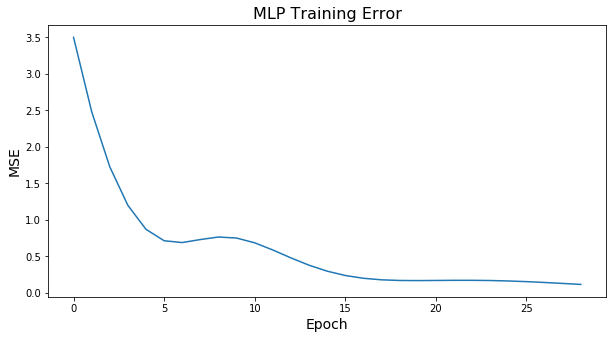

[3.14191373 3.00291173 3.62098113 2.73389261 2.70317398] => 3.04 (+/- 0.67)
[3.23749282 3.60601228 9.06881133 8.19243454 1.97384405] => 5.22 (+/- 5.71)



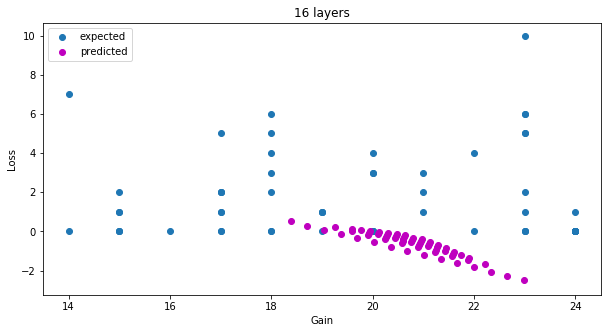

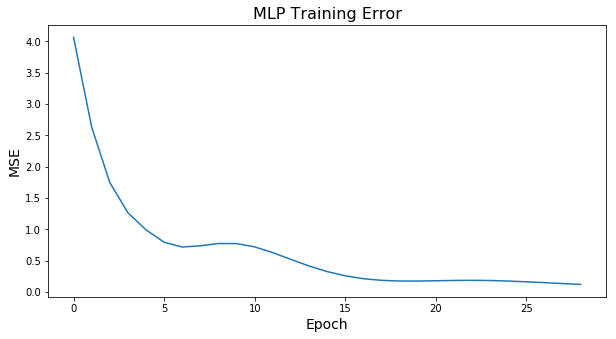

[3.36801747 3.08896246 4.03608151 2.56346837 2.95065772] => 3.20 (+/- 0.98)
[2.07558095 2.06991346 1.68879952 1.91416916 0.7466247 ] => 1.70 (+/- 0.99)



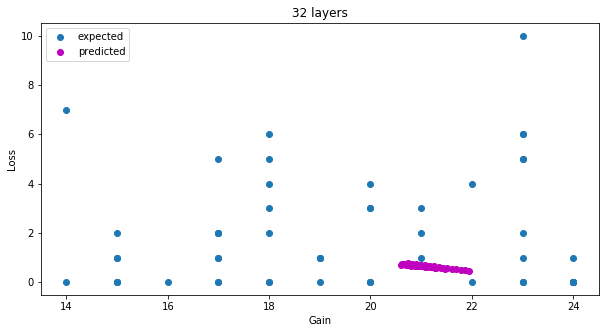

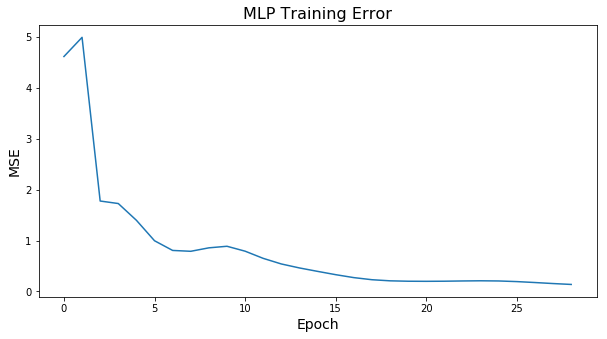

AttributeError: 'MultiOutputRegressor' object has no attribute 'loss_curve_'

In [9]:
for layers in layerArray:
    regressor = setMLP(layers)
    trainModel(regressor)
    plotDistribution(regressor, layers)
    plotTrainError(regressor)

regressor = MultiOutputRegressor(KNeighborsRegressor())
trainModel(regressor)
plotKNNTrainError(regressor)

print("Done!")

# Plotting graphs

In [ ]:
#plotGainError()

In [ ]:
#plotLossError()